In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, sum

from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .getOrCreate()

In [3]:
schema = StructType([
    StructField("Dato", StringType(), True),
    StructField("Track", StringType(), True),
    StructField("Race Number", IntegerType(), True),
    StructField("Distance", IntegerType(), True),
    StructField("Surface", StringType(), True),
    StructField("Prize money", IntegerType(), True),
    StructField("Starting position", IntegerType(), True),
    StructField("Jockey", StringType(), True),
    StructField("Jockey weight", IntegerType(), True),
    StructField("Country", StringType(), True),
    StructField("Horse age", IntegerType(), True),
    StructField("TrainerName", StringType(), True),
    StructField("Race time", StringType(), True),
    StructField("Path", IntegerType(), True),
    StructField("Final place", IntegerType(), True),
    StructField("FGrating", IntegerType(), True),
    StructField("Odds", IntegerType(), True),
    StructField("RaceType", StringType(), True),
    StructField("HorseId", IntegerType(), True),
    StructField("JockeyId", IntegerType(), True),
    StructField("TrainerID", IntegerType(), True)
])

In [4]:
df = spark.read.csv("data\Horse Racing Results.CSV", header=True, sep=";", schema=schema)

In [5]:
df.printSchema()

root
 |-- Dato: string (nullable = true)
 |-- Track: string (nullable = true)
 |-- Race Number: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- Surface: string (nullable = true)
 |-- Prize money: integer (nullable = true)
 |-- Starting position: integer (nullable = true)
 |-- Jockey: string (nullable = true)
 |-- Jockey weight: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Horse age: integer (nullable = true)
 |-- TrainerName: string (nullable = true)
 |-- Race time: string (nullable = true)
 |-- Path: integer (nullable = true)
 |-- Final place: integer (nullable = true)
 |-- FGrating: integer (nullable = true)
 |-- Odds: integer (nullable = true)
 |-- RaceType: string (nullable = true)
 |-- HorseId: integer (nullable = true)
 |-- JockeyId: integer (nullable = true)
 |-- TrainerID: integer (nullable = true)



In [6]:
df.show(5)

+----------+-------+-----------+--------+-------+-----------+-----------------+-------------+-------------+-------+---------+-----------+---------+----+-----------+--------+----+--------+-------+--------+---------+
|      Dato|  Track|Race Number|Distance|Surface|Prize money|Starting position|       Jockey|Jockey weight|Country|Horse age|TrainerName|Race time|Path|Final place|FGrating|Odds|RaceType|HorseId|JockeyId|TrainerID|
+----------+-------+-----------+--------+-------+-----------+-----------------+-------------+-------------+-------+---------+-----------+---------+----+-----------+--------+----+--------+-------+--------+---------+
|03.09.2017|Sha Tin|         10|    1400|  Gress|    1310000|                6|    K C Leung|           52|Sverige|        7|     CH Yip|    83,38|   2|          9|     110|  22|Handicap|   1736|    8656|     6687|
|16.09.2017|Sha Tin|         10|    1400|  Gress|    1310000|               14|       C Y Ho|           52|Sverige|        7|     CH Yip|   

In [7]:
df_pandas = df.toPandas()

In [8]:
df_pandas

,Dato,Track,Race Number,Distance,Surface,Prize money,Starting position,Jockey,Jockey weight,Country,...,TrainerName,Race time,Path,Final place,FGrating,Odds,RaceType,HorseId,JockeyId,TrainerID
0,03.09.2017,Sha Tin,10,1400,Gress,1310000,6,K C Leung,52,Sverige,...,CH Yip,"83,38",2,9,110,22.0,Handicap,1736,8656,6687
1,16.09.2017,Sha Tin,10,1400,Gress,1310000,14,C Y Ho,52,Sverige,...,CH Yip,"81,56",3,4,124,48.0,Handicap,1736,8659,6687
2,14.10.2017,Sha Tin,10,1400,Gress,1310000,8,C Y Ho,52,Sverige,...,CH Yip,"82,36",1,6,118,11.0,Handicap,1736,8659,6687
3,11.11.2017,Sha Tin,9,1600,Gress,1310000,13,Brett Prebble,54,Sverige,...,CH Yip,"96,53",0,8,107,11.0,Handicap,1736,8453,6687
4,26.11.2017,Sha Tin,9,1600,Gress,1310000,9,C Y Ho,52,Sverige,...,CH Yip,"94,17",0,3,123,40.0,Handicap,1736,8659,6687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27003,14.06.2020,Sha Tin,11,1200,Gress,1450000,6,A Hamelin,59,Australia,...,WY So,"70,87",1,9,104,25.0,Handicap,29038,9111,6683
27004,21.06.2020,Sha Tin,2,1200,Gress,967000,7,K C Leung,57,Australia,...,KL Man,"69,91",2,5,110,124.0,Handicap,29056,8656,6693
27005,21.06.2020,Sha Tin,4,1200,Gress,967000,6,Blake Shinn,57,Australia,...,P O'Sullivan,"69,49",0,3,114,88.0,Handicap,29057,8778,6691
27006,21.06.2020,Sha Tin,5,1200,Gress,967000,14,Joao Moreira,57,New Zealand,...,AS Cruz,"70,08",2,7,109,22.0,Handicap,29058,8443,6684


In [9]:
df.describe().show()

+-------+----------+------------+------------------+------------------+-------+------------------+-----------------+--------+------------------+---------+------------------+-----------+------------------+------------------+------------------+------------------+-----------------+------------+------------------+-----------------+-----------------+
|summary|      Dato|       Track|       Race Number|          Distance|Surface|       Prize money|Starting position|  Jockey|     Jockey weight|  Country|         Horse age|TrainerName|         Race time|              Path|       Final place|          FGrating|             Odds|    RaceType|           HorseId|         JockeyId|        TrainerID|
+-------+----------+------------+------------------+------------------+-------+------------------+-----------------+--------+------------------+---------+------------------+-----------+------------------+------------------+------------------+------------------+-----------------+------------+------------

In [10]:
for columna in df.columns:
    print(f"Columna '{columna}' tiene {df.select(columna).distinct().count()} valores únicos.")

Columna 'Dato' tiene 240 valores únicos.
Columna 'Track' tiene 2 valores únicos.
Columna 'Race Number' tiene 11 valores únicos.
Columna 'Distance' tiene 9 valores únicos.
Columna 'Surface' tiene 2 valores únicos.
Columna 'Prize money' tiene 39 valores únicos.
Columna 'Starting position' tiene 14 valores únicos.
Columna 'Jockey' tiene 89 valores únicos.
Columna 'Jockey weight' tiene 16 valores únicos.
Columna 'Country' tiene 17 valores únicos.
Columna 'Horse age' tiene 10 valores únicos.
Columna 'TrainerName' tiene 86 valores únicos.
Columna 'Race time' tiene 3925 valores únicos.
Columna 'Path' tiene 12 valores únicos.
Columna 'Final place' tiene 14 valores únicos.
Columna 'FGrating' tiene 141 valores únicos.
Columna 'Odds' tiene 443 valores únicos.
Columna 'RaceType' tiene 4 valores únicos.
Columna 'HorseId' tiene 2297 valores únicos.
Columna 'JockeyId' tiene 89 valores únicos.
Columna 'TrainerID' tiene 86 valores únicos.


In [11]:
null_counts = df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns])

null_counts.show()

+----+-----+-----------+--------+-------+-----------+-----------------+------+-------------+-------+---------+-----------+---------+----+-----------+--------+----+--------+-------+--------+---------+
|Dato|Track|Race Number|Distance|Surface|Prize money|Starting position|Jockey|Jockey weight|Country|Horse age|TrainerName|Race time|Path|Final place|FGrating|Odds|RaceType|HorseId|JockeyId|TrainerID|
+----+-----+-----------+--------+-------+-----------+-----------------+------+-------------+-------+---------+-----------+---------+----+-----------+--------+----+--------+-------+--------+---------+
|   0|    0|          0|       0|      0|          0|                0|     0|            0|      0|        0|          0|        0|   0|          0|       0|8428|       0|      0|       0|        0|
+----+-----+-----------+--------+-------+-----------+-----------------+------+-------------+-------+---------+-----------+---------+----+-----------+--------+----+--------+-------+--------+---------+


In [12]:
indexer_jockey = StringIndexer(inputCol="Jockey", outputCol="JockeyIndex")
indexer_race_type = StringIndexer(inputCol="RaceType", outputCol="RaceTypeIndex")
indexer_surface = StringIndexer(inputCol="Surface", outputCol="SurfaceIndex")

encoder_jockey = OneHotEncoder(inputCol="JockeyIndex", outputCol="JockeyOneHot")
encoder_race_type = OneHotEncoder(inputCol="RaceTypeIndex", outputCol="RaceTypeOneHot")
encoder_surface = OneHotEncoder(inputCol="SurfaceIndex", outputCol="SurfaceOneHot")

pipeline = Pipeline(stages=[indexer_jockey, indexer_race_type, indexer_surface, encoder_jockey, encoder_race_type, encoder_surface])

model = pipeline.fit(df)
data_encoded = model.transform(df)

In [13]:
data_encoded.toPandas().head()

,Dato,Track,Race Number,Distance,Surface,Prize money,Starting position,Jockey,Jockey weight,Country,...,RaceType,HorseId,JockeyId,TrainerID,JockeyIndex,RaceTypeIndex,SurfaceIndex,JockeyOneHot,RaceTypeOneHot,SurfaceOneHot
0,03.09.2017,Sha Tin,10,1400,Gress,1310000,6,K C Leung,52,Sverige,...,Handicap,1736,8656,6687,4.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)",(1.0)
1,16.09.2017,Sha Tin,10,1400,Gress,1310000,14,C Y Ho,52,Sverige,...,Handicap,1736,8659,6687,3.0,0.0,0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)",(1.0)
2,14.10.2017,Sha Tin,10,1400,Gress,1310000,8,C Y Ho,52,Sverige,...,Handicap,1736,8659,6687,3.0,0.0,0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)",(1.0)
3,11.11.2017,Sha Tin,9,1600,Gress,1310000,13,Brett Prebble,54,Sverige,...,Handicap,1736,8453,6687,28.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)",(1.0)
4,26.11.2017,Sha Tin,9,1600,Gress,1310000,9,C Y Ho,52,Sverige,...,Handicap,1736,8659,6687,3.0,0.0,0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)",(1.0)


In [14]:
numeric_feature_cols = ["Race Number", "Distance", "Prize money", "Starting position", "Jockey weight", "Horse age"]

categorical_feature_cols = ["JockeyOneHot", "RaceTypeOneHot", "SurfaceOneHot"]

feature_cols = numeric_feature_cols + categorical_feature_cols

feature_cols

['Race Number',
 'Distance',
 'Prize money',
 'Starting position',
 'Jockey weight',
 'Horse age',
 'JockeyOneHot',
 'RaceTypeOneHot',
 'SurfaceOneHot']

In [15]:
train_ratio = 0.8
test_ratio = 1 - train_ratio

train_data, test_data = data_encoded.randomSplit([train_ratio, test_ratio], seed=123)

print("Cantidad de datos en el conjunto de entrenamiento:", train_data.count())
print("Cantidad de datos en el conjunto de prueba:", test_data.count())

Cantidad de datos en el conjunto de entrenamiento: 21506
Cantidad de datos en el conjunto de prueba: 5502


In [16]:
# Crear un VectorAssembler que tome en cuenta todas las características
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

lr = LinearRegression(featuresCol="features", labelCol="Final place")

pipeline = Pipeline(stages=[assembler, lr])

model = pipeline.fit(train_data)

predictions = model.transform(test_data)


evaluator = RegressionEvaluator(labelCol="Final place", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE:", rmse)

RMSE: 3.4775510997368326


In [17]:
print(type(predictions))

<class 'pyspark.sql.dataframe.DataFrame'>


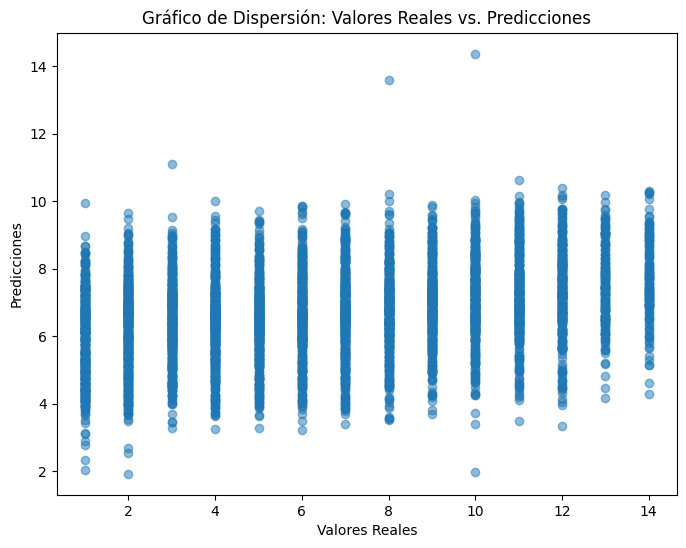

In [18]:
actual = predictions.select("Final place").rdd.flatMap(lambda x: x).collect()
predicted = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 6))
plt.scatter(actual, predicted, alpha=0.5)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Gráfico de Dispersión: Valores Reales vs. Predicciones")
plt.show()

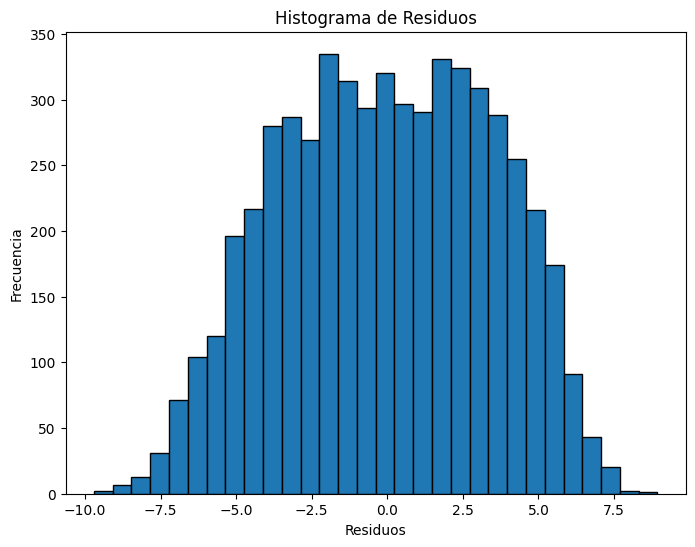

In [24]:
residuals = predictions.rdd.map(lambda x: x["prediction"] - x["Final place"]).collect()

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de Residuos")
plt.show()


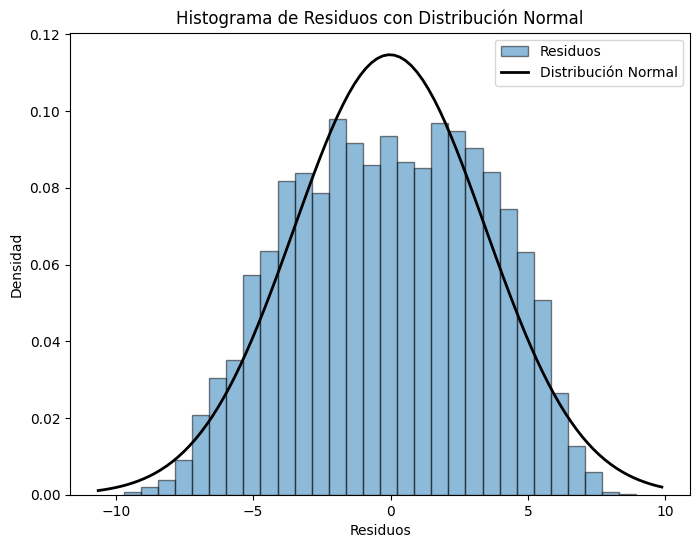

In [29]:
from scipy.stats import norm

residuals = predictions.rdd.map(lambda x: x["prediction"] - x["Final place"]).collect()

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', density=True, alpha=0.5, label="Residuos")

mu, std = norm.fit(residuals)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2, label="Distribución Normal")

plt.xlabel("Residuos")
plt.ylabel("Densidad")
plt.title("Histograma de Residuos con Distribución Normal")
plt.legend()
plt.show()
